# Code listing
## Homework 2: Models for regression
> Matheus Ferreira Lessa - 374947
> 
> 

## Inicializações

In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
from scipy.stats import skew
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_validate, cross_val_score, KFold, GridSearchCV, cross_val_predict
from sklearn.preprocessing import PowerTransformer
from sklearn.cross_decomposition import PLSRegression
sns.set_style("whitegrid")

In [2]:
continuous_predictors = ["MolWeight", "NumAtoms", "NumNonHAtoms", "NumBonds", "NumNonHBonds", "NumMultBonds", "NumRotBonds", "NumDblBonds", "NumAromaticBonds", "NumHydrogen", "NumCarbon", "NumNitrogen", "NumOxygen", "NumSulfer", "NumChlorine", "NumHalogen", "NumRings", "HydrophilicFactor", "SurfaceArea1", "SurfaceArea2", "x"]


In [3]:
X = pd.read_csv("solubility/solTrainXtrans.txt", delimiter="\t")
Xtest = pd.read_csv("solubility/solTestXtrans.txt", delimiter="\t")
X.index = range(1, len(X) + 1)
Y = pd.read_csv("solubility/solTrainY.txt", delimiter="\t")
Ytest = pd.read_csv("solubility/solTestY.txt", delimiter="\t")

## Análise e pré-processamento dos dados

In [4]:
data = X.join(Y)

In [5]:
test = pd.concat([X[continuous_predictors[:-1]], Xtest[continuous_predictors[:-1]]], axis=0)
data_analysis = {
    'Min': np.amin(test),
    'Max': np.amax(test),
    'Mean': np.mean(test),
    'Std': np.std(test),
    'Skewness': skew(test)
}

df = pd.DataFrame(data_analysis)
df.style

,Min,Max,Mean,Std,Skewness
MolWeight,3.85206,6.50251,5.19169,0.472869,0.00788832
NumAtoms,1.79176,4.55388,3.16629,0.454895,-0.0766653
NumNonHAtoms,1.09861,3.8712,2.54237,0.451329,-0.061827
NumBonds,1.60944,4.58497,3.16875,0.486318,-0.199768
NumNonHBonds,0.743492,5.97701,3.35193,0.872842,0.0297517
NumMultBonds,0,6.97989,2.59974,1.71457,-0.106119
NumRotBonds,0,2.83321,0.901067,0.715065,0.148971
NumDblBonds,0,1.18804,0.388139,0.380187,0.194826
NumAromaticBonds,0,3.3322,1.30636,1.12386,-0.180654
NumHydrogen,0,7.31425,3.67727,1.18026,-0.0365868


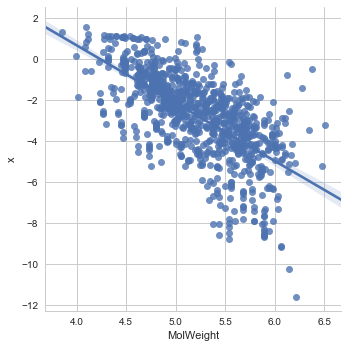

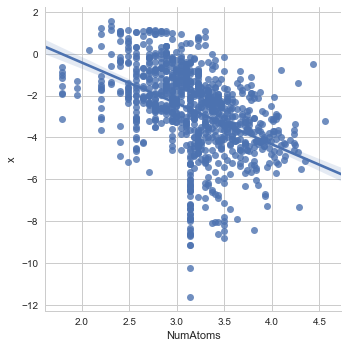

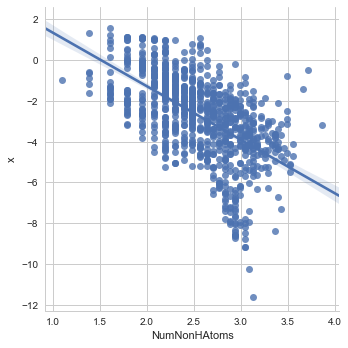

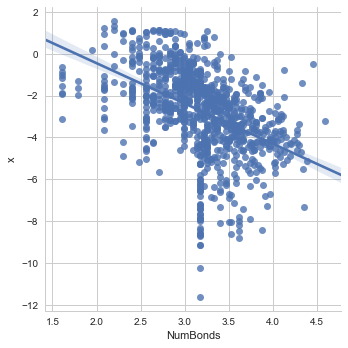

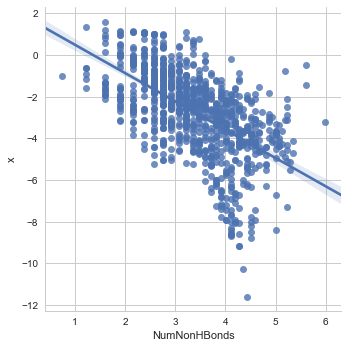

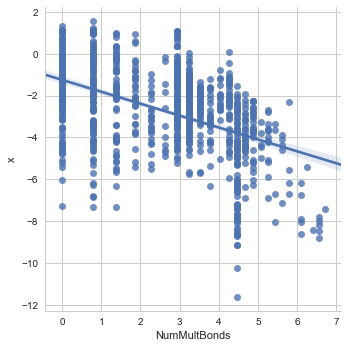

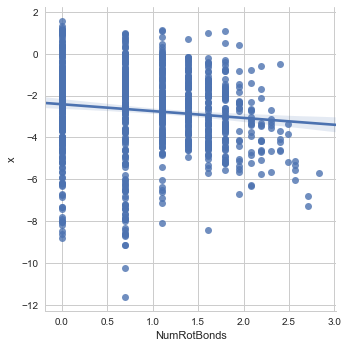

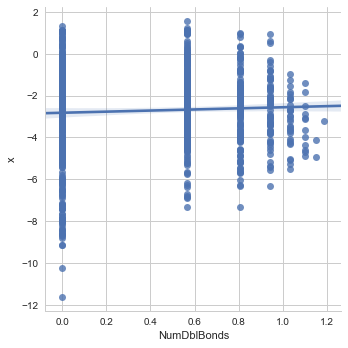

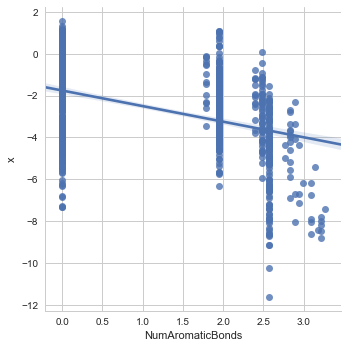

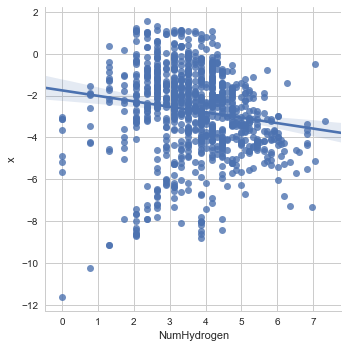

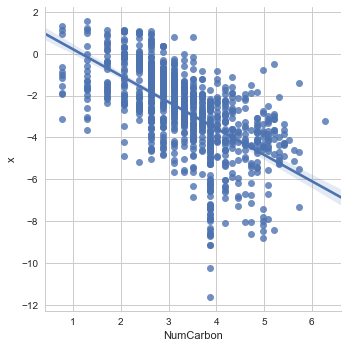

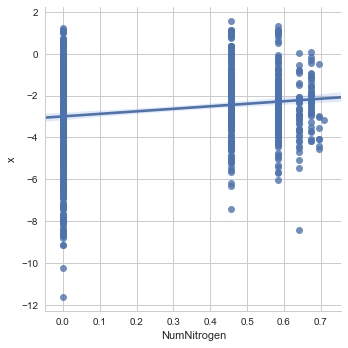

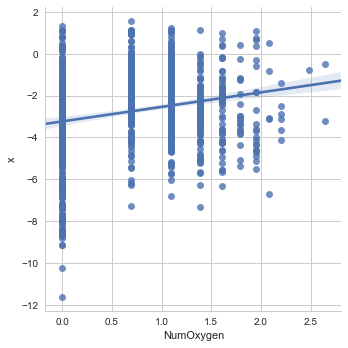

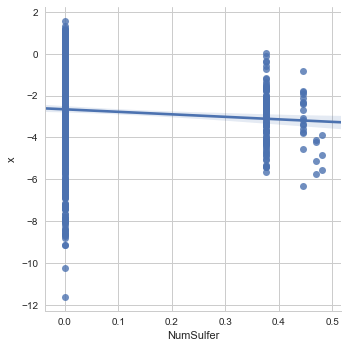

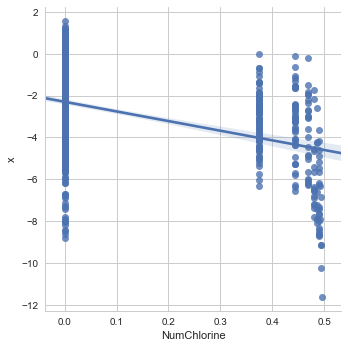

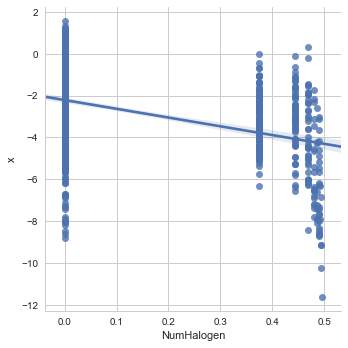

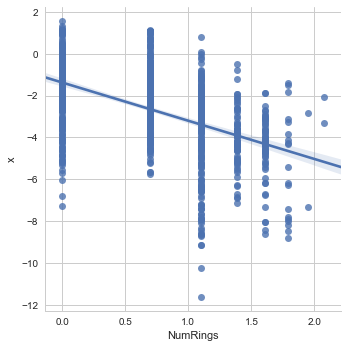

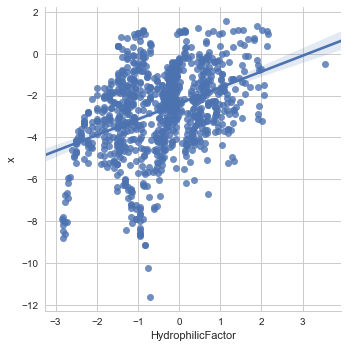

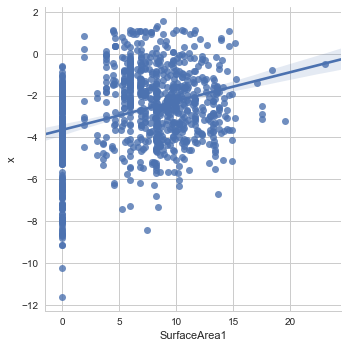

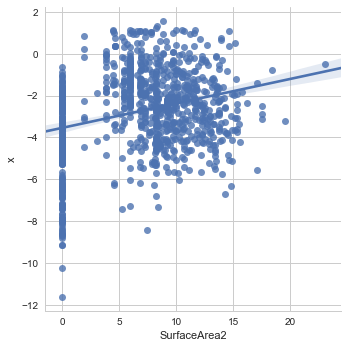

In [6]:
for x in continuous_predictors[:-1]:
    sns.lmplot(x=x, y="x", data=data)    
plt.show()

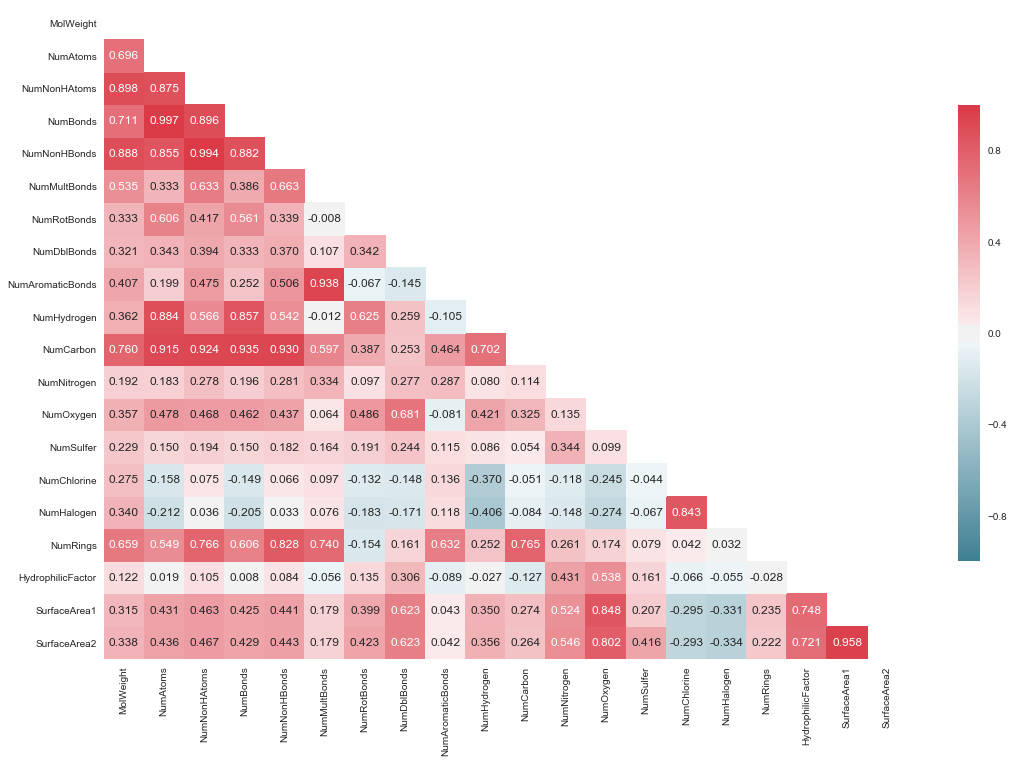

In [7]:
corr = X[continuous_predictors[:-1]].corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

figure, axis = plt.subplots(figsize=(18, 12))

axis = sns.heatmap(
    corr,
    mask=mask,
    annot= True,
    fmt=".3f",
    vmin=-1.0, vmax=1.0, center=0,
    cmap=sns.diverging_palette(220, 10, n=7, as_cmap=True),
    cbar_kws={"shrink": .7}
)

plt.show()

## Modelo de regressão linear ordinária (OLR)

In [8]:
lm = LinearRegression()
model = lm.fit(X, Y)
Ypred = model.predict(Xtest)

print('RMSE', np.sqrt(mean_squared_error(Ytest, Ypred)))
print('R2', r2_score(Ytest, Ypred))

RMSE 0.745580189650894
R2 0.8709146842068278


### Cross-validation

In [9]:
lin_reg = LinearRegression()
MSEs = cross_val_score(lin_reg, X, Y, scoring="neg_mean_squared_error", cv=10)
mean_MSE = np.mean(MSEs)
print(np.sqrt(np.abs(mean_MSE)))

0.7563265449594019


In [10]:
kf = KFold(n_splits=10, random_state=100, shuffle=True)

R2 = []
RMSE = []

for train_index, test_index in kf.split(X):
    x_train = X.iloc[train_index]
    y_train = Y.iloc[train_index]

    x_test  = X.iloc[test_index]
    y_test  = Y.iloc[test_index]

    # if needed, do preprocessing here

    lm = LinearRegression()
    lm.fit(x_train, y_train)

    preds = lm.predict(x_test)

    RMSE.append(np.sqrt(mean_squared_error(y_test, preds)))
    R2.append(r2_score(y_test, preds))

# this is the average accuracy over all folds
print('RMSE', np.mean(RMSE))
print('R2', np.mean(R2))

RMSE 0.7194162446075112
R2 0.867470340106762


### Gráficos do resultado da OLR

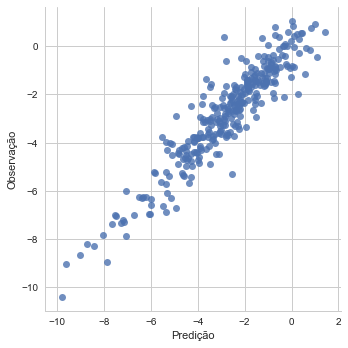

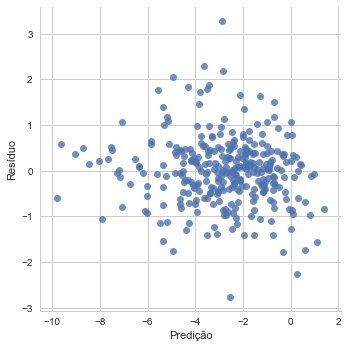

In [11]:
Ypred_ = sum(Ypred.tolist(), [])
Ytest_ = sum(Ytest.values.tolist(), [])
resid = [y_test - y_pred for y_test, y_pred in zip(Ytest_, Ypred_)]

df1 = pd.DataFrame({'Predição': Ypred_, 'Observação': Ytest_})
sns.lmplot(x='Predição', y="Observação", data=df1, fit_reg=False)

df2 = pd.DataFrame({'Predição': Ypred_, 'Resíduo': resid})
sns.lmplot(x='Predição', y="Resíduo", data=df2, fit_reg=False)

plt.show()

### Removendo os preditores altamente correlacionados

In [12]:
# Create correlation matrix
corr_matrix = X.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.90
to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]

# Drop features 
newX = X.drop(to_drop, axis=1)
newXtest = Xtest.drop(to_drop, axis=1)

model2 = LinearRegression().fit(newX, Y)
Ypred2 = model2.predict(newXtest)

print('RMSE', np.sqrt(mean_squared_error(Ytest, Ypred2)))
print('R2', r2_score(Ytest, Ypred2))

RMSE 0.7429178357036604
R2 0.8718349264734622


## Modelo de regressão linear penalizado L2 (Ridge)

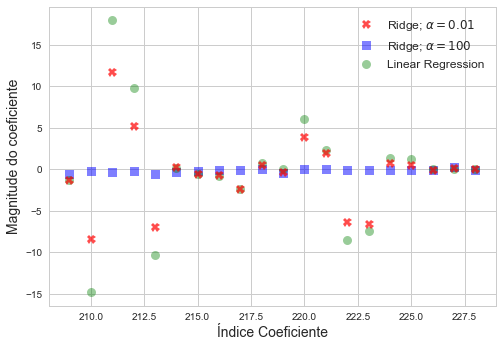

In [13]:
lr = LinearRegression()
lr.fit(X, Y)

rr = Ridge(alpha=0.01) 
rr.fit(X, Y)

rr100 = Ridge(alpha=100) #  comparison with alpha value
rr100.fit(X, Y)

plt.plot(range(209, 229), rr.coef_[0][208:],alpha=0.7,linestyle='none',marker='X',markersize=9,color='red',label=r'Ridge; $\alpha = 0.01$',zorder=7) # zorder for ordering the markers
plt.plot(range(209, 229), rr100.coef_[0][208:],alpha=0.5,linestyle='none',marker='s',markersize=9,color='blue',label=r'Ridge; $\alpha = 100$') # alpha here is for transparency
plt.plot(range(209, 229), lr.coef_[0][208:],alpha=0.4,linestyle='none',marker='o',markersize=9,color='green',label='Linear Regression')

plt.xlabel('Índice Coeficiente',fontsize=14)
plt.ylabel('Magnitude do coeficiente',fontsize=14)
plt.legend(fontsize=12,loc=1)
plt.show()


In [14]:
ridge = Ridge()
params = {'alpha': np.linspace(0.1,15,100)}
ridge_regressor = GridSearchCV(ridge, params, scoring=('r2', 'neg_mean_squared_error'), cv=10, refit='neg_mean_squared_error')
ridge_regressor.fit(X, Y)

print(ridge_regressor.best_params_)
print(np.sqrt(np.abs(ridge_regressor.best_score_)))

{'alpha': 8.377777777777776}
0.702535933125867


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


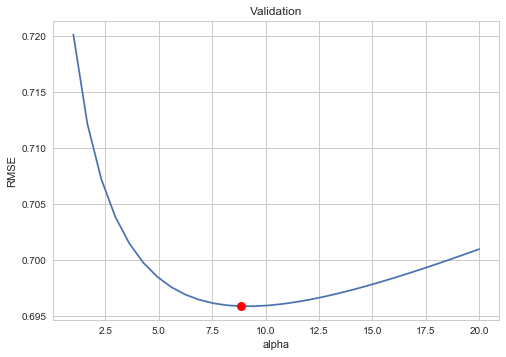

In [15]:
alphas = np.linspace(1,20,30)
cv_ridge = [np.sqrt(-cross_val_score(Ridge(alpha = alpha), X, Y, scoring="neg_mean_squared_error", cv = 10)).mean() for alpha in alphas]
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation")

alpha_min = alphas[cv_ridge.tolist().index(cv_ridge.min())]

plt.xlabel("alpha")
plt.ylabel("RMSE")
plt.plot(alpha_min, cv_ridge.min(), marker='o', markersize=9, color='red')
plt.show()


# 9.165495495495495

In [20]:
alphas = np.linspace(0.01,0.1,15)
r2 = [(cross_val_score(Ridge(alpha = alpha), X, Y, scoring="r2", cv = 10)).mean() for alpha in alphas]
rmse = [np.sqrt(-cross_val_score(Ridge(alpha = alpha), X, Y, scoring="neg_mean_squared_error", cv = 10)).mean() for alpha in alphas]

df = pd.DataFrame(
    {
        'alpha': alphas,
        'RMSE': rmse,
        'R2': r2
    }
)
df

,alpha,RMSE,R2
0,0.010000,0.746995,-3.382235
1,0.016429,0.746546,-3.344076
2,0.022857,0.746450,-3.320078
3,0.029286,0.746435,-3.302932
4,0.035714,0.746418,-3.289538
5,0.042143,0.746375,-3.278387
6,0.048571,0.746298,-3.268672
7,0.055000,0.746191,-3.259930
8,0.061429,0.746056,-3.251879
9,0.067857,0.745897,-3.244340


## Regressão parcial dos mínimos quadrados (PLS)

19 0.7361631410892919


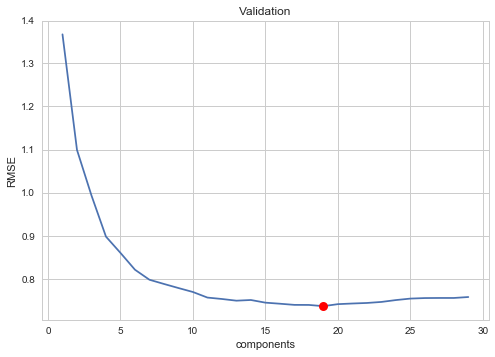

In [17]:
components = range(1,30)

cv_pls = [np.sqrt(-cross_val_score(PLSRegression(n_components=comps), X, Y, scoring="neg_mean_squared_error", cv = 10)).mean() for comps in components]
cv_pls = pd.Series(cv_pls, index = components)

cv_pls.plot(title = "Validation")

n_comp_min = components[cv_pls.tolist().index(cv_pls.min())]

print(n_comp_min, cv_pls.min())

plt.xlabel("components")
plt.ylabel("RMSE")
plt.plot(n_comp_min, cv_pls.min(), marker='o', markersize=9, color='red')
plt.show()

In [18]:
# Define PLS object
pls = PLSRegression(n_components=19)
# Fit
pls.fit(X, Y)
Ypred_pls = pls.predict(Xtest)
Ytest_pls = Ytest

# Calculate scores
score = r2_score(Ytest_pls, Ypred_pls)
rmse = np.sqrt(mean_squared_error(Ytest_pls, Ypred_pls))

print(score)
print(rmse)

0.8756252345390564
0.7318499992933137


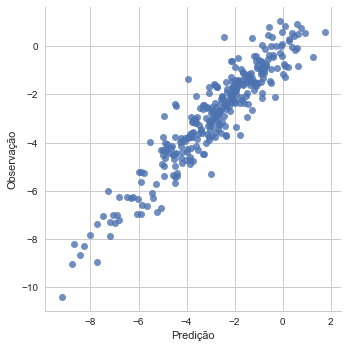

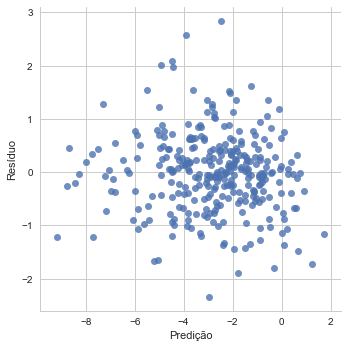

In [19]:
Ypred_ = sum(Ypred_pls.tolist(), [])
Ytest_ = sum(Ytest_pls.values.tolist(), [])
resid = [y_test - y_pred for y_test, y_pred in zip(Ytest_, Ypred_)]

df1 = pd.DataFrame({'Predição': Ypred_, 'Observação': Ytest_})
sns.lmplot(x='Predição', y="Observação", data=df1, fit_reg=False)

df2 = pd.DataFrame({'Predição': Ypred_, 'Resíduo': resid})
sns.lmplot(x='Predição', y="Resíduo", data=df2, fit_reg=False)

plt.show()